In [24]:
import sys
sys.path.append("..")

In [25]:
import default_config as cfg
import remote_storage_config as storage_cfg

cfg.__dict__.update(storage_cfg.__dict__)

In [26]:

cfg.SHUFFLE=False

In [27]:
import ipywidgets as widgets
import datetime
import tensorflow as tf
import numpy as np

import dataset_functions
import models.six_stage_linear_model as model
import callbacks
import dataset_builder
import load_weights

In [28]:
import matplotlib.pyplot as plt
import visualizations as v

In [29]:
model_ds=model.ModelDatasetComponent(cfg)

tfrecord_files_train=dataset_builder.get_tfrecord_filenames(cfg.TRAIN_TFRECORDS,cfg)
tfrecord_files_valid=dataset_builder.get_tfrecord_filenames(cfg.VALID_TFRECORDS,cfg)
print("Found the following training TFrecords:\n","\n".join(tfrecord_files_train))
print("Found the following validation TFrecords:\n","\n".join(tfrecord_files_valid))

print("Building training dataset")
dst=dataset_builder.build_training_ds(tfrecord_files_train,model_ds.place_training_labels,cfg)
print("Training dataset shape:",dst)
print("Building validation dataset")
dsv=dataset_builder.build_validation_ds(tfrecord_files_valid,model_ds.place_training_labels,cfg)
print("Validation dataset shape:",dsv)


Retrieving TFrecords from: gs://datasets_bucket_a/training
Retrieving TFrecords from: gs://datasets_bucket_a/validation
Found the following training TFrecords:
 gs://datasets_bucket_a/training-001.tfrecords
gs://datasets_bucket_a/training-002.tfrecords
gs://datasets_bucket_a/training-003.tfrecords
gs://datasets_bucket_a/training-004.tfrecords
gs://datasets_bucket_a/training-005.tfrecords
gs://datasets_bucket_a/training-006.tfrecords
gs://datasets_bucket_a/training-007.tfrecords
gs://datasets_bucket_a/training-008.tfrecords
gs://datasets_bucket_a/training-009.tfrecords
gs://datasets_bucket_a/training-010.tfrecords
gs://datasets_bucket_a/training-011.tfrecords
gs://datasets_bucket_a/training-012.tfrecords
gs://datasets_bucket_a/training-013.tfrecords
gs://datasets_bucket_a/training-014.tfrecords
gs://datasets_bucket_a/training-015.tfrecords
gs://datasets_bucket_a/training-016.tfrecords
gs://datasets_bucket_a/training-017.tfrecords
gs://datasets_bucket_a/training-018.tfrecords
gs://datase

In [80]:
checkpoint="gs://dl_training_results/checkpoints/model714Sat1219-0044/-E0036.ckpt"

In [81]:
model_maker=model.ModelMaker(cfg) 
tf.keras.backend.clear_session() 
train_model,test_model=model_maker.create_models()
train_model.load_weights(checkpoint)

In [71]:
train_model.save("../tmp/train_"+cfg.RUN_NAME) 

INFO:tensorflow:Assets written to: ../tmp/train_/assets


In [72]:
train_model=tf.keras.models.load_model("../tmp/train_"+cfg.RUN_NAME)

---
## Dataset input (truth)

In [36]:
#service functions
def remove_mask(inp):
    return inp[...,:-1]
def decmopose_ds_elem(st,idx):
    img=st[0][0][idx:idx+1].numpy()
    paf=st[1][3][idx:idx+1].numpy()
    kpt=st[1][5][idx:idx+1].numpy()
    
    paf=remove_mask(paf)
    kpt=remove_mask(kpt)
    return img,(paf,),(kpt,)

def get_train_model_output(model,st,idx):
    
    img=st[0][0][idx:idx+1].numpy() #get img from sample tensor
    empty_mask=np.zeros((1,46,46,1)) #generate mask
    inputs=(img,empty_mask) #bundle
    
    pred_t=train_model.predict(inputs) #actual prediction
    
    paf0=remove_mask(pred_t[0])
    paf1=remove_mask(pred_t[1])
    paf2=remove_mask(pred_t[2])
    paf3=remove_mask(pred_t[3])
    kpt0=remove_mask(pred_t[4])
    kpt1=remove_mask(pred_t[5])
    
    return img,(paf0,paf1,paf2,paf3),(kpt0,kpt1)

def extract_single_paf(paf,idx):
    ldim=int(paf.shape[-1]/2)
    return np.stack([paf[...,idx],paf[...,idx+ldim]],axis=-1)

In [73]:
it=iter(dst)

In [74]:
st=next(it)
idx=0

In [49]:
idx=idx+1

In [55]:
joint_num=-1#-1 to show all, otherwise joint num to isolate

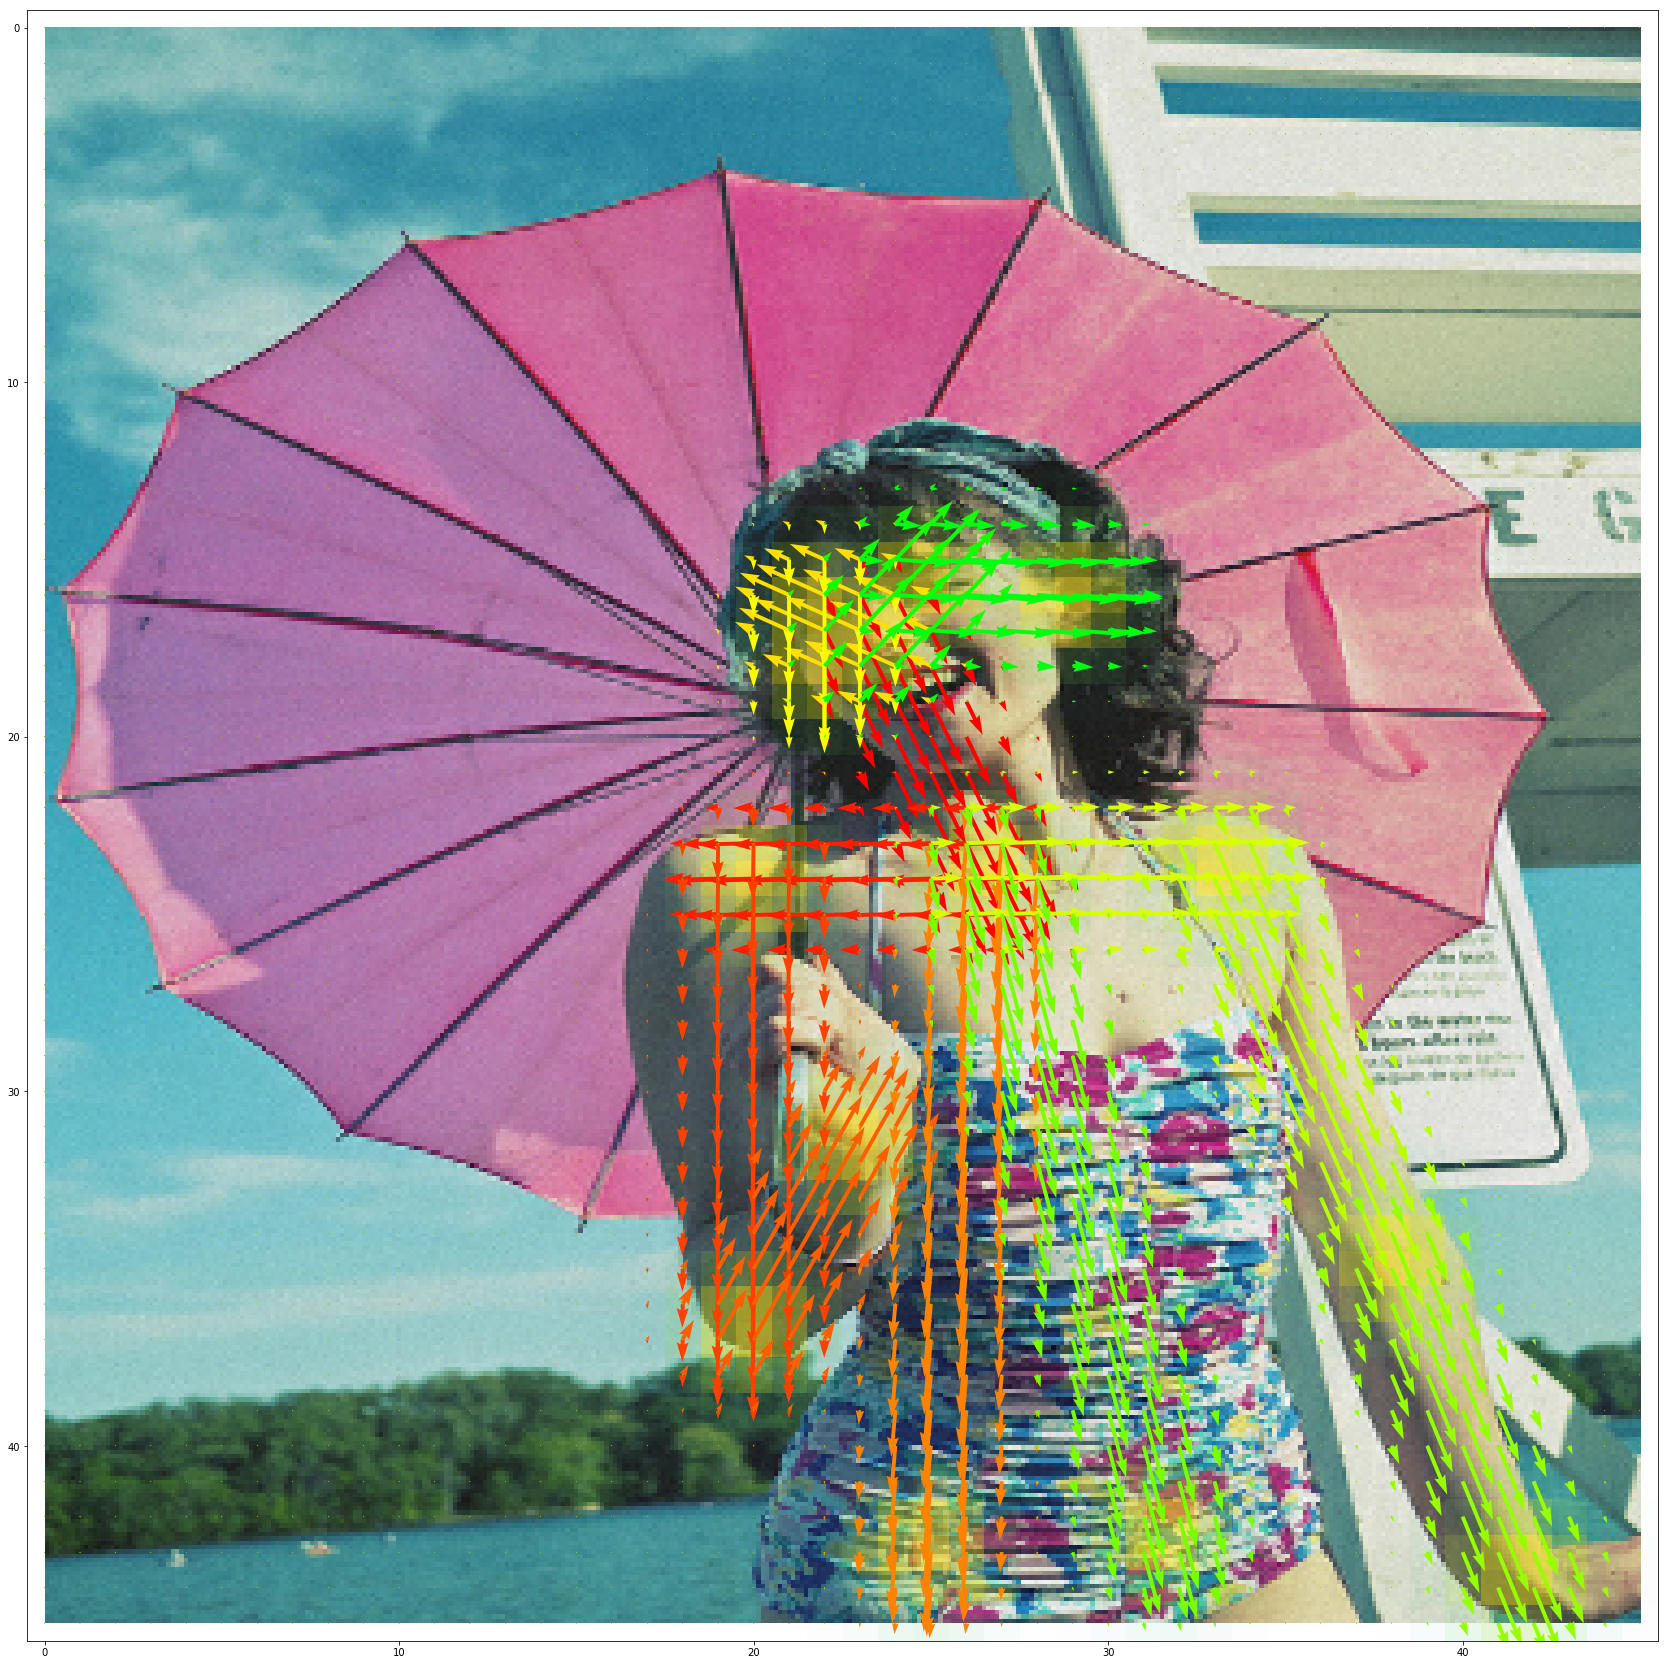

In [75]:
img,(paf,),(kpt,)=decmopose_ds_elem(st,idx)
if joint_num>0:paf=extract_single_paf(paf,joint_num)
if joint_num>0:kpt=kpt[...,x:x+1]
v.show_img_pafs_kpts(img,paf,kpt,figure_size=30)

---
## Model prediction

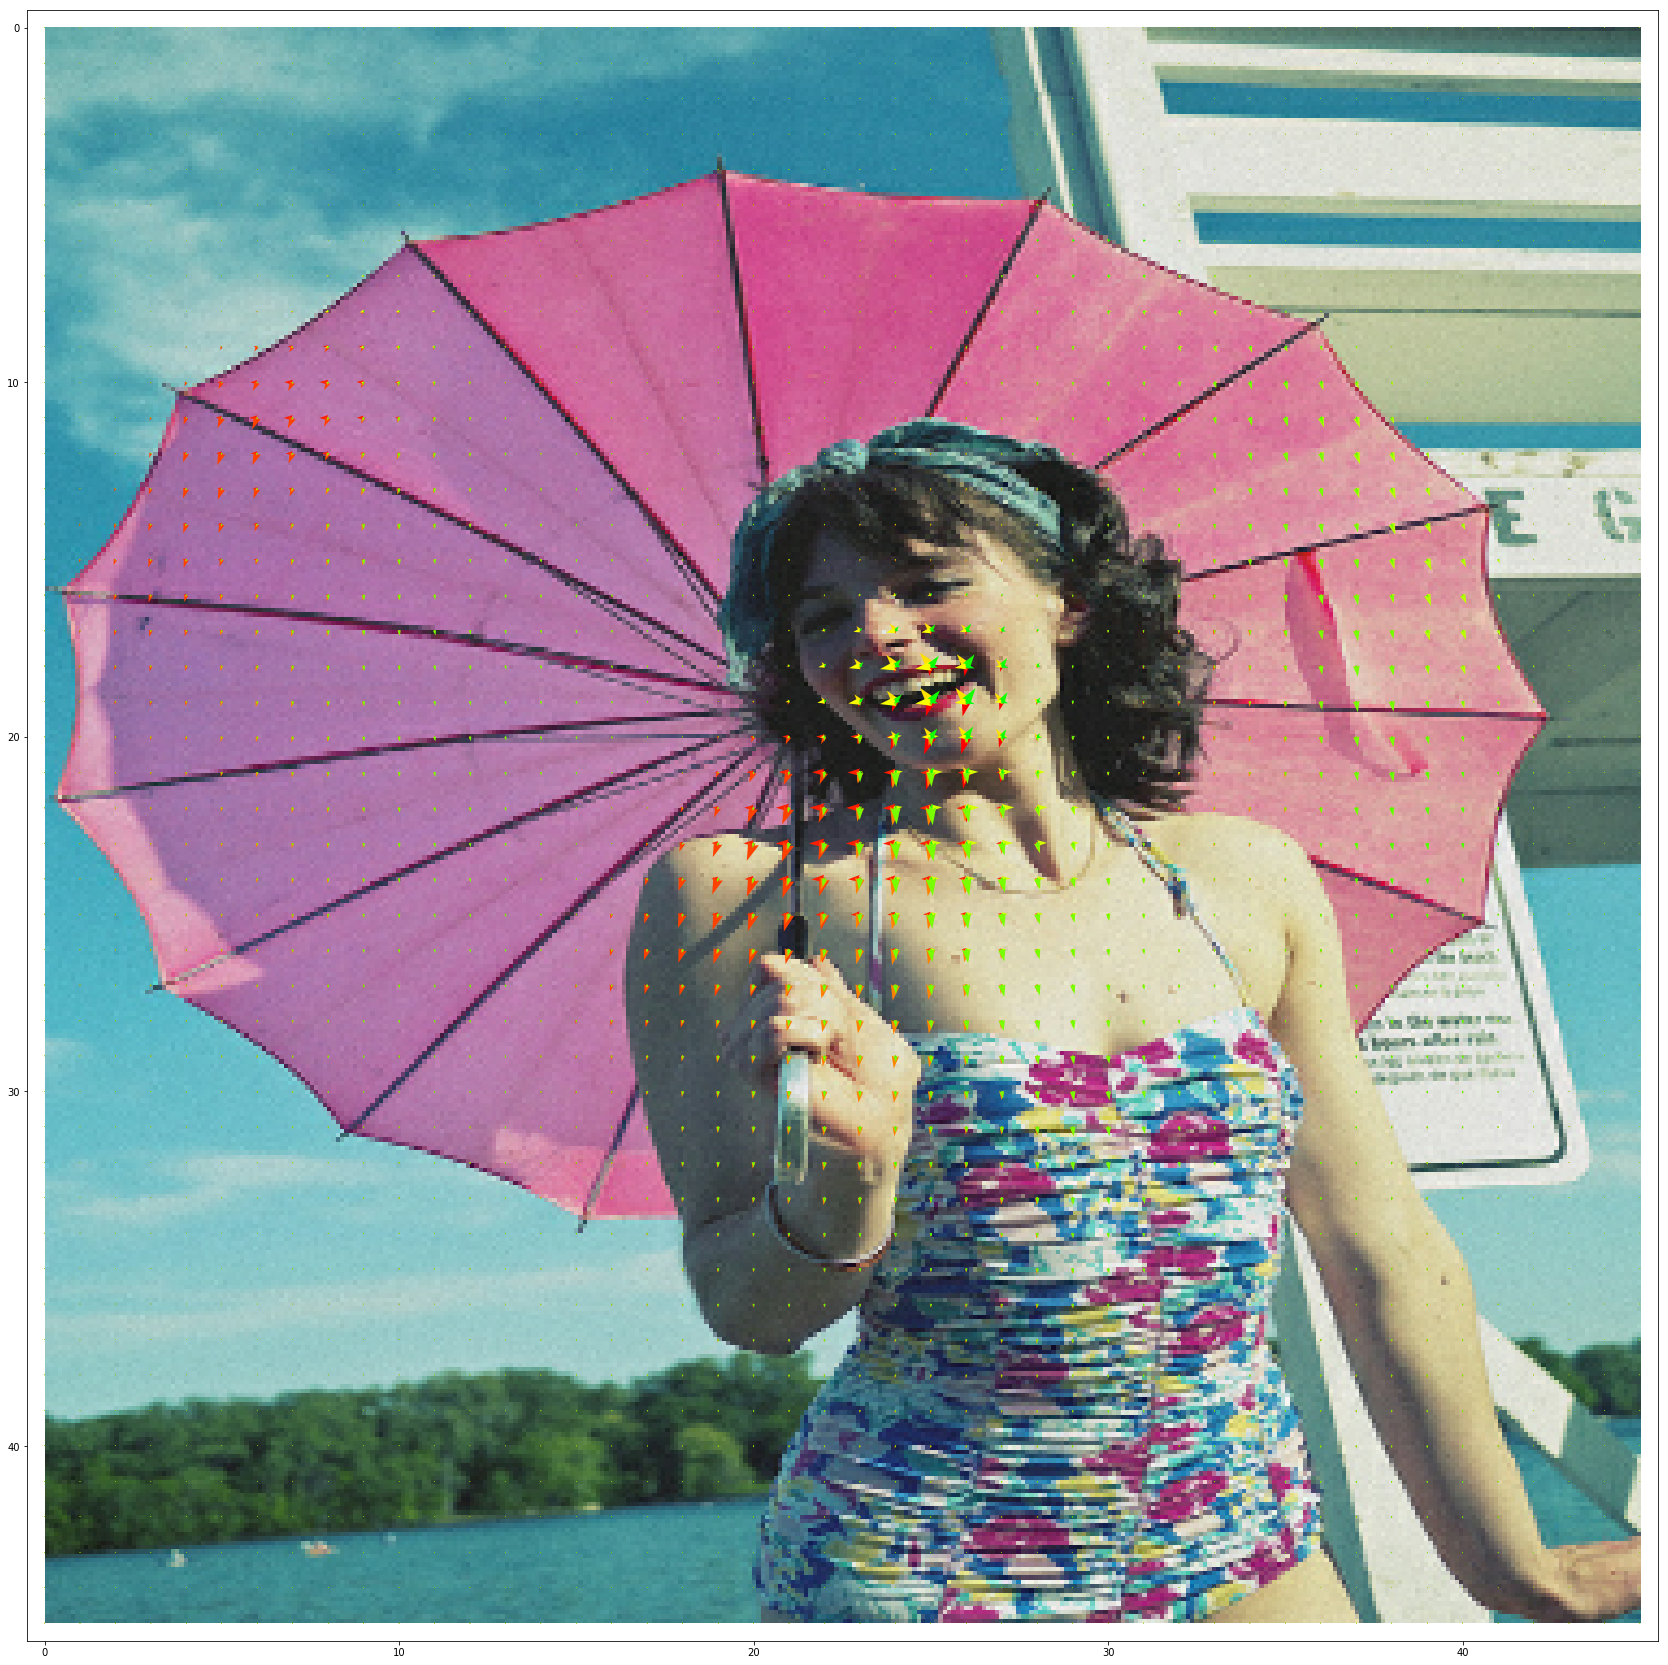

In [82]:
img,(paf0,paf1,paf2,paf3),(kpt0,kpt1)=get_train_model_output(train_model,st,idx)
paf=paf3 #select the outoput to check
kpt=kpt1
if joint_num>0:
    paf=extract_single_paf(paf,joint_num)
v.show_img_pafs_kpts(img,paf,kpt,figure_size=30)